In [7]:
import pandas as pd
import numpy as np
import os
import shutil
import glob

from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.resnet import preprocess_input, ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten , Dense
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report

In [8]:
NEW_DIR = "./database/"
ROOT_DIR = "./images/"

TRAIN_PATH  = "./database/train_test_split/train"
VALID_PATH  = "./database/train_test_split/validation"
TEST_PATH   = "./database/train_test_split/test"

objArrayDiseases = ["COVID", "Normal", "Pneumonia"]

In [9]:
objArrayCovid = pd.read_excel("./metadatas/covid.metadata.xlsx")
objArrayNormal = pd.read_excel("./metadatas/normal.metadata.xlsx")
objArrayPneumonia = pd.read_excel("./metadatas/pneumonia.metadata.xlsx")

In [10]:
for imgfile in glob.iglob(os.path.join(os.path.join(ROOT_DIR, "Pneumonia/"), "*.png")):
    os.rename(imgfile, imgfile.replace('Viral ', ''))

In [11]:
if not os.path.exists(NEW_DIR):
  os.mkdir(NEW_DIR)

  for i in objArrayDiseases:
    org_dir = os.path.join(ROOT_DIR, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, NEW_DIR)
      
else:
  print("Already Exist")

In [12]:
if not os.path.exists(NEW_DIR+"train_test_split/"):

  os.makedirs(NEW_DIR+"train_test_split/")

  os.makedirs(NEW_DIR+"train_test_split/train/Normal")
  os.makedirs(NEW_DIR+"train_test_split/train/COVID")
  os.makedirs(NEW_DIR+"train_test_split/train/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/test/Normal")
  os.makedirs(NEW_DIR+"train_test_split/test/COVID")
  os.makedirs(NEW_DIR+"train_test_split/test/Pneumonia")

  os.makedirs(NEW_DIR+"train_test_split/validation/Normal")
  os.makedirs(NEW_DIR+"train_test_split/validation/COVID")
  os.makedirs(NEW_DIR+"train_test_split/validation/Pneumonia")


  # Train Data
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/train/Pneumonia" )
    os.remove(i)


  # Validation Data
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/validation/Pneumonia" )
    os.remove(i)

  # Test Data
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[0]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/COVID" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(NEW_DIR+objArrayDiseases[1]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(NEW_DIR+objArrayDiseases[2]+"*") ):
    shutil.copy(i , NEW_DIR+"train_test_split/test/Pneumonia" )
    os.remove(i)    

In [13]:
objTrainGenerator = ImageDataGenerator(preprocessing_function= preprocess_input, 
                                    zoom_range= 0.2, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    
                                    )

objTrain = objTrainGenerator.flow_from_directory(directory= TRAIN_PATH, 
                                           target_size=(224,224))

Found 7800 images belonging to 3 classes.


In [14]:
objValidGenerator = ImageDataGenerator(preprocessing_function= preprocess_input  )

objValid = objValidGenerator.flow_from_directory(directory= VALID_PATH, 
                                                target_size=(224,224))

Found 1008 images belonging to 3 classes.


In [15]:
objTestGenerator = ImageDataGenerator(preprocessing_function= preprocess_input )

objTest = objTestGenerator.flow_from_directory(directory= TEST_PATH , 
                                          target_size=(224,224), 
                                          shuffle= False)

Found 800 images belonging to 3 classes.


In [16]:
classifier = ResNet50( input_shape=(224,224,3), include_top= False)

for layer in classifier.layers:       
  layer.trainable = False

94773248/94765736 [==============================] - 9s 0us/step


In [17]:
print (classifier.output)

objLayers = Flatten()(classifier.output)
objLayers = Dense(units=3 , activation='sigmoid', name = 'predictions' )(objLayers)

objModel = Model(classifier.input, objLayers)
objModel.compile( optimizer= 'adam' , loss = 'categorical_crossentropy', metrics=['accuracy'])
objModel.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 2048), dtype=tf.float32, name=None), name='conv5_block3_out/Relu:0', description="created by layer 'conv5_block3_out'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormal

In [18]:
earlyStopping = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
modelCheckpoint = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [19]:
objFit = objModel.fit_generator(objTrain, steps_per_epoch= 10, epochs= 30, validation_data=objValid , validation_steps= 16, callbacks=[earlyStopping, modelCheckpoint])

C:\Users\Divergente\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 96s 10s/step - loss: 10.0063 - accuracy: 0.6125 - val_loss: 4.2939 - val_accuracy: 0.7812

Epoch 00001: val_accuracy improved from -inf to 0.78125, saving model to bestmodel.h5


C:\Users\Divergente\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/30
10/10 [==============================] - 91s 10s/step - loss: 5.1246 - accuracy: 0.7563 - val_loss: 2.8050 - val_accuracy: 0.8359

Epoch 00002: val_accuracy improved from 0.78125 to 0.83594, saving model to bestmodel.h5
Epoch 3/30
10/10 [==============================] - 91s 10s/step - loss: 2.9450 - accuracy: 0.8375 - val_loss: 2.9425 - val_accuracy: 0.8574

Epoch 00003: val_accuracy improved from 0.83594 to 0.85742, saving model to bestmodel.h5
Epoch 4/30
10/10 [==============================] - 93s 10s/step - loss: 2.5137 - accuracy: 0.8625 - val_loss: 2.5389 - val_accuracy: 0.8867

Epoch 00004: val_accuracy improved from 0.85742 to 0.88672, saving model to bestmodel.h5
Epoch 5/30
10/10 [==============================] - 88s 9s/step - loss: 2.0955 - accuracy: 0.8781 - val_loss: 2.6780 - val_accuracy: 0.8730

Epoch 00005: val_accuracy did not improve from 0.88672
Epoch 6/30
10/10 [==============================] - 85s 9s/step - loss: 2.1639 - accuracy: 0.8562 - val_loss: 4

In [20]:
objModel = load_model("bestmodel.h5")

nr_Acurracy = objModel.evaluate_generator(generator=objTest)[1] 

print(f"A acurácia do modelo selecionado foi de = {nr_Acurracy}%")

C:\Users\Divergente\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2002: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


A acurácia do modelo selecionado foi de = 0.8525000214576721%


In [23]:
true_classes = objTest.classes
class_labels = list(objTest.class_indices.keys())   

predictions = objModel.predict_generator(objTest)
predictions = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predictions, target_names=class_labels)
print(report)    

C:\Users\Divergente\AppData\Local\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:2030: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


              precision    recall  f1-score   support

       COVID       0.93      0.81      0.87       300
      Normal       0.72      0.95      0.82       300
   Pneumonia       0.99      0.71      0.83       200

    accuracy                           0.84       800
   macro avg       0.88      0.83      0.84       800
weighted avg       0.87      0.84      0.84       800



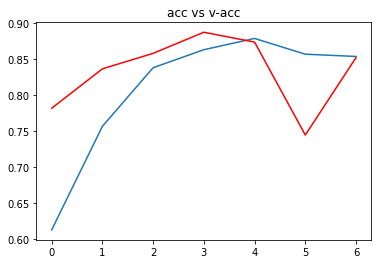

In [24]:
objHistory = objFit.history

plt.plot(objHistory['accuracy'])
plt.plot(objHistory['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()

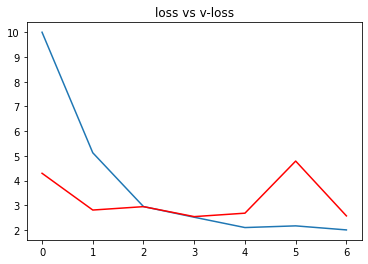

In [25]:
objHistory = objFit.history

plt.plot(objHistory['loss'])
plt.plot(objHistory['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

A imagem é da seguinte class: Normal

As chances da imagem ser da classe COVID é: 9.300303105419516e-06 porcento

As chances da imagem ser da classe Normal é: 100.0 porcento

As chances da imagem ser da classe Pneumonia é: 1.5566006528009043e-14 porcento


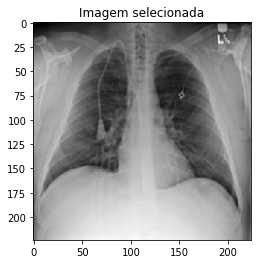

In [31]:
def Get_Image(ds_Image_Path):
  path = ds_Image_Path
  objImage = image.load_img(path, target_size=(224,224,3))
  objImage = image.img_to_array(objImage)
  objImage = np.expand_dims(objImage , axis= 0 )
  
  return objImage


ds_Image_Path = "./database/Normal-5.png"   
objImage = Get_Image(ds_Image_Path)

objClassType = {0:'Covid',  1 : 'Normal', 2: 'Pneumonia'}

res = objClassType[np.argmax(objModel.predict(objImage))]

print(f"A imagem é da seguinte class: {res}")
print()
print(f"As chances da imagem ser da classe COVID é: {objModel.predict(objImage)[0][0]*100} porcento")
print()
print(f"As chances da imagem ser da classe Normal é: {objModel.predict(objImage)[0][1]*100} porcento")
print()
print(f"As chances da imagem ser da classe Pneumonia é: {objModel.predict(objImage)[0][2]*100} porcento")

plt.imshow(objImage[0]/255, cmap = "gray")
plt.title("Imagem selecionada")
plt.show()